In [1]:
# Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 17.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
open

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import time

# --- Load the Dataset ---
# IMPORTANT: Make sure the path to your file is correct.
try:
    file_path = '/content/drive/MyDrive/Depression detection dataset/BSMDD_main.xlsx'
    df = pd.read_excel(file_path)
    print("Dataset loaded successfully!")
    print("First 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file was not found at the specified path.")
    print("Please double-check the file path and try again.")
    df = None

# Display basic information about the dataset
if df is not None:
    print("\nDataset Info:")
    df.info()

Dataset loaded successfully!
First 5 rows of the dataset:
                                        text_bengali  \
0  মানসিক শারীরিকভাবে অসুস্থ ক্লান্ত পুরো জীবন শা...   
1  দয়া সাথে থাকুন অত্যন্ত দীর্ঘ আপনাকে পড়তে উত্...   
2  জানতাম সাথে ভুল লোক খারাপ জীবন কাটিয়েছে সম্পূ...   
3  অনেটিভ ইংরেজি স্পিকারের অনুসরণ বিরক্তিকর অপ্রত...   
4  অনেটিভ ইংরেজি স্পিকারের অনুসরণ বিরক্তিকর অপ্রত...   

                                       text_banglish  label  
0  manasika sharirikabhabe asustha klanta puro ji...      1  
1  daya sathe thakuna atyanta dirgha apanake pada...      1  
2  janatama sathe bhula loka kharapa jibana katiy...      1  
3  anetibha imreji spikarera anusarana biraktikar...      1  
4  anetibha imreji spikarera anusarana biraktikar...      1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21910 entries, 0 to 21909
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_bengali   2191

In [3]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
# Download the 'punkt' tokenizer from NLTK
# This is required for word_tokenize
nltk.download('punkt')

# --- Data Cleaning and Preprocessing ---

# 1. Drop rows with missing text
df.dropna(subset=['text_banglish'], inplace=True)

# 2. Rename 'Label' to 'label' for consistency
if 'Label' in df.columns:
    df.rename(columns={'Label': 'label'}, inplace=True)

# 3. Define a function to clean the text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

# Apply the cleaning function
df['cleaned_text'] = df['text_banglish'].apply(clean_text)

# 4. Tokenize the text
df['tokenized_text'] = df['cleaned_text'].apply(word_tokenize)

# Display the first few rows with the new columns
print("DataFrame after preprocessing and tokenization:")
print(df[['text_banglish', 'cleaned_text', 'tokenized_text', 'label']].head())

# Display dataset info to check for null values again
print("\nDataset Info after cleaning:")
df.info()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


DataFrame after preprocessing and tokenization:
                                       text_banglish  \
0  manasika sharirikabhabe asustha klanta puro ji...   
1  daya sathe thakuna atyanta dirgha apanake pada...   
2  janatama sathe bhula loka kharapa jibana katiy...   
3  anetibha imreji spikarera anusarana biraktikar...   
4  anetibha imreji spikarera anusarana biraktikar...   

                                        cleaned_text  \
0  manasika sharirikabhabe asustha klanta puro ji...   
1  daya sathe thakuna atyanta dirgha apanake pada...   
2  janatama sathe bhula loka kharapa jibana katiy...   
3  anetibha imreji spikarera anusarana biraktikar...   
4  anetibha imreji spikarera anusarana biraktikar...   

                                      tokenized_text  label  
0  [manasika, sharirikabhabe, asustha, klanta, pu...      1  
1  [daya, sathe, thakuna, atyanta, dirgha, apanak...      1  
2  [janatama, sathe, bhula, loka, kharapa, jibana...      1  
3  [anetibha, imreji, spikarer

In [5]:
# --- Train Custom Word2Vec Model ---

# The tokenized text will be our corpus for training
sentences = df['tokenized_text'].tolist()

print("Starting Word2Vec model training...")

# Parameters:
# vector_size: The dimensionality of the word vectors. 100 is a good starting point.
# window: The maximum distance between the current and predicted word within a sentence.
# min_count: Ignores all words with a total frequency lower than this.
# workers: Use these many worker threads to train the model (faster training).
word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2, workers=4)

print("Word2Vec model training completed.")

# Save the trained model for later use
word2vec_model.save("word2vec.model")
print("Word2Vec model saved to 'word2vec.model'")

Starting Word2Vec model training...
Word2Vec model training completed.
Word2Vec model saved to 'word2vec.model'


In [6]:
# --- Prepare Data for the LSTM Model ---

# 1. Keras Tokenizer for integer encoding
# We create a new vocabulary based on our tokenized text.
# The <OOV> token is for words that are not in the vocabulary.
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['tokenized_text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # Add 1 for the padding token

print(f"Found {len(word_index)} unique tokens in the dataset.")

# 2. Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['tokenized_text'])

# 3. Pad sequences to ensure uniform length
# We'll use a max length of 192, which is suitable for this kind of text data.
max_length = 192
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

print(f"Padding sequences to a max length of: {max_length}")

# 4. Create the Embedding Matrix
embedding_dim = 100  # This must match the vector_size from our Word2Vec model
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
# Words not found in Word2Vec will be all zeros.

print(f"Embedding Matrix Shape: {embedding_matrix.shape}")


# --- Split Data into Training and Testing Sets ---
X = padded_sequences
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nData splitting complete.")
print(f"Training data shape (X_train): {X_train.shape}")
print(f"Testing data shape (X_test): {X_test.shape}")

Found 56827 unique tokens in the dataset.
Padding sequences to a max length of: 192
Embedding Matrix Shape: (56828, 100)

Data splitting complete.
Training data shape (X_train): (17528, 192)
Testing data shape (X_test): (4382, 192)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# --- Build and Compile the Model (Improved Version) ---

# Clear any previous models from memory
tf.keras.backend.clear_session()

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True
    ),
    LSTM(units=64),
    Dropout(0.5),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# 1. Use a lower learning rate for more stable training
optimizer = Adam(learning_rate=0.0001)

# 2. Compile the model with the new optimizer
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Define the EarlyStopping callback
# It will monitor 'val_loss' and stop training if it doesn't improve for 3 epochs.
# restore_best_weights=True ensures the model reverts to the best version.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

print("Model re-compiled with a lower learning rate and Early Stopping.")
model.summary()

Model re-compiled with a lower learning rate and Early Stopping.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     5,682,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,682,800 (21.68 MB)

 Trainable params: 5,682,800 (21.68 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# --- Train the Model ---

print("Starting model training...")

# Define training parameters
epochs = 20
batch_size = 32

# Start the timer
start_time = time.time()

# Fit the model to the training data
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test)
)

# End the timer
end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining finished in {training_time:.2f} seconds.")

Starting model training...
Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 105s 185ms/step - accuracy: 0.5022 - loss: 0.6922 - precision: 0.5068 - recall: 0.3825 - val_accuracy: 0.5196 - val_loss: 0.6884 - val_precision: 0.6667 - val_recall: 0.0794
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 103s 188ms/step - accuracy: 0.5387 - loss: 0.6781 - precision: 0.6604 - recall: 0.1579 - val_accuracy: 0.8279 - val_loss: 0.4734 - val_precision: 0.8230 - val_recall: 0.8358
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 103s 188ms/step - accuracy: 0.8171 - loss: 0.4813 - precision: 0.8391 - recall: 0.7835 - val_accuracy: 0.8063 - val_loss: 0.4714 - val_precision: 0.7477 - val_recall: 0.9247
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 142s 188ms/step - accuracy: 0.8228 - loss: 0.4631 - precision: 0.7789 - recall: 0.9015 - val_accuracy: 0.8263 - val_loss: 0.4628 - val_precision: 0.8263 - val_recall: 0.8266
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 142s 187ms/step - accuracy: 0.8286 - loss: 0.4620 - precision: 0.8168 - recal

In [16]:
# --- Re-run Training with the EarlyStopping Callback ---

print("Starting model training with Early Stopping...")

# We are using the 'early_stopping' callback we defined earlier.
# The 'model' object is already compiled with the better learning rate.

epochs = 20
batch_size = 32

# Start the timer
start_time = time.time()

# Fit the model, this time correctly passing the callback
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # <-- This is the crucial addition
)

# End the timer
end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining finished in {training_time:.2f} seconds.")
print("The model has been restored to the weights of the best epoch.")

Starting model training with Early Stopping...
Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 106s 188ms/step - accuracy: 0.5024 - loss: 0.6925 - precision: 0.5132 - recall: 0.3202 - val_accuracy: 0.5180 - val_loss: 0.6889 - val_precision: 0.6653 - val_recall: 0.0734
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 143s 190ms/step - accuracy: 0.5085 - loss: 0.6896 - precision: 0.5285 - recall: 0.2421 - val_accuracy: 0.5262 - val_loss: 0.6858 - val_precision: 0.5139 - val_recall: 0.9790
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 102s 185ms/step - accuracy: 0.6231 - loss: 0.6244 - precision: 0.6638 - recall: 0.4661 - val_accuracy: 0.8122 - val_loss: 0.4811 - val_precision: 0.8552 - val_recall: 0.7518
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 103s 188ms/step - accuracy: 0.8286 - loss: 0.4679 - precision: 0.8375 - recall: 0.8165 - val_accuracy: 0.8005 - val_loss: 0.4920 - val_precision: 0.7477 - val_recall: 0.9074
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 142s 189ms/step - accuracy: 0.8194 - loss: 0.4708 - preci

137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step
--- Overall Test Metrics ---
Accuracy:  0.8252
Precision: 0.8034
Recall:    0.8613
F1 Score:  0.8314
ROC-AUC Score: 0.8768

Classification Report:
                   precision    recall  f1-score   support

Not Depressed (0)       0.85      0.79      0.82      2190
    Depressed (1)       0.80      0.86      0.83      2192

         accuracy                           0.83      4382
        macro avg       0.83      0.83      0.82      4382
     weighted avg       0.83      0.83      0.82      4382


Confusion Matrix:


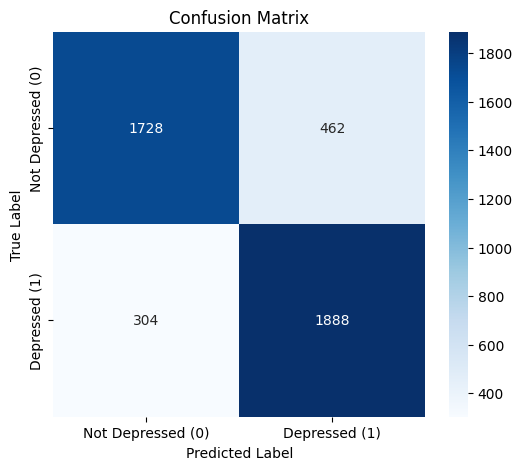

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Final Performance Evaluation ---

# 1. Get model predictions on the test set
# .predict() gives probabilities, so we convert them to 0 or 1
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# 2. Calculate and print overall metrics
print("--- Overall Test Metrics ---")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob) # Use probabilities for ROC-AUC

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# 3. Print the detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Depressed (0)', 'Depressed (1)']))

# 4. Display the Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Depressed (0)', 'Depressed (1)'],
            yticklabels=['Not Depressed (0)', 'Depressed (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
import os

# --- Time Complexity ---
print("--- Time Complexity ---")
# The 'training_time' variable was just updated by the last training run.
print(f"Total Training Time: {training_time:.2f} seconds (approx. {training_time/60:.1f} minutes)")

# Measure inference time for the final model
inference_start_time = time.time()
model.predict(X_test, batch_size=batch_size)
inference_end_time = time.time()
total_inference_time = inference_end_time - inference_start_time
avg_inference_time_ms = (total_inference_time / len(X_test)) * 1000

print(f"Total Inference Time for {len(X_test)} samples: {total_inference_time:.4f} seconds")
print(f"Average Inference Time per Sample: {avg_inference_time_ms:.4f} milliseconds")

# --- Space Complexity ---
print("\n--- Space Complexity ---")
# Save the final, best model to a file
model_filename = 'depression_detection_lstm_best.keras'
model.save(model_filename)

# Get the size of the saved model file
model_size_bytes = os.path.getsize(model_filename)
model_size_mb = model_size_bytes / (1024 * 1024)

print(f"Total Model Parameters: {model.count_params():,}")
print(f"Model Size on Disk: {model_size_mb:.2f} MB")

--- Time Complexity ---
Total Training Time: 982.48 seconds (approx. 16.4 minutes)
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
Total Inference Time for 4382 samples: 4.3874 seconds
Average Inference Time per Sample: 1.0012 milliseconds

--- Space Complexity ---
Total Model Parameters: 5,727,153
Model Size on Disk: 65.58 MB


In [19]:
import pickle

# Save the Keras Tokenizer to a file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer has been saved to 'tokenizer.pickle'")

Tokenizer has been saved to 'tokenizer.pickle'


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 192, 100)       │     5,682,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,181,461 (65.54 MB)

 Trainable params: 5,727,153 (21.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,454,308 (43.69 MB)